# Train Model with GPU (and CPU*)

In [2]:
import tensorflow as tf
from tensorflow.python.client import timeline
import pylab
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tf.logging.set_verbosity(tf.logging.INFO)

In [3]:
tf.reset_default_graph()

In [4]:
num_samples = 100000

In [5]:
from datetime import datetime 

version = int(datetime.now().strftime("%s"))

### Load Model Training and Test/Validation Data 


[ 0.93815309  0.54280561  0.59591198 ...,  0.49807525  0.47904432
  0.32933131]
[ 0.39556992  0.36064481  0.36168211 ...,  0.35649814  0.36016553
  0.30659009]


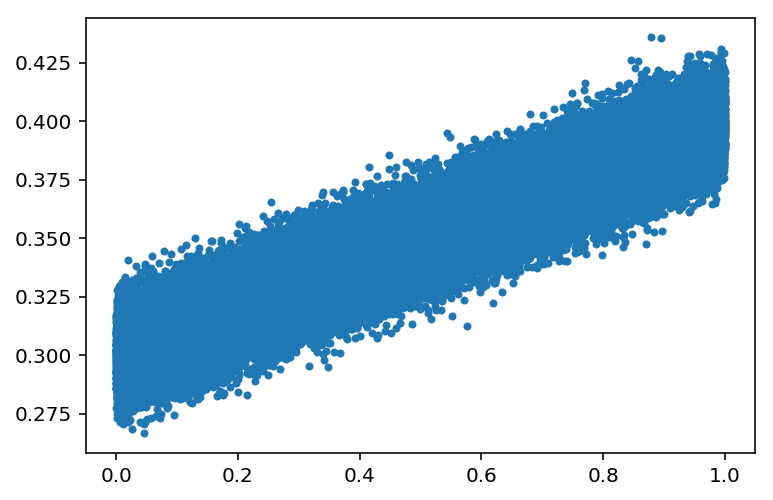

In [6]:
x_train = np.random.rand(num_samples).astype(np.float32)
print(x_train)

noise = np.random.normal(scale=0.01, size=len(x_train))

y_train = x_train * 0.1 + 0.3 + noise
print(y_train)

pylab.plot(x_train, y_train, '.')

[ 0.04737252  0.04632433  0.05839991 ...,  0.98732018  0.62846726
  0.0682414 ]
[ 0.3071676   0.30426243  0.31248351 ...,  0.39245852  0.36601611
  0.29659531]


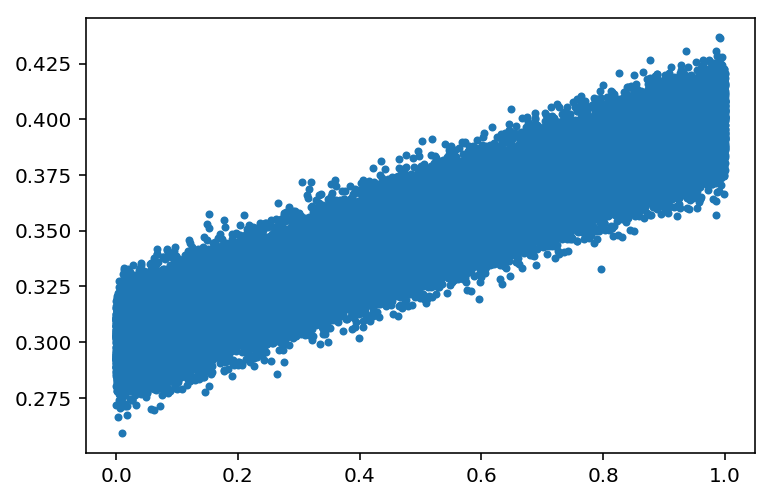

In [7]:
x_test = np.random.rand(len(x_train)).astype(np.float32)
print(x_test)

noise = np.random.normal(scale=.01, size=len(x_train))

y_test = x_test * 0.1 + 0.3 + noise
print(y_test)

pylab.plot(x_test, y_test, '.')

In [8]:
with tf.device("/cpu:0"):
  W = tf.get_variable(shape=[], name='weights')
  print(W)

  b = tf.get_variable(shape=[], name='bias')
  print(b)

  x_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='x_observed')
  print(x_observed)

with tf.device("/gpu:0"):
  y_pred = W * x_observed + b
  print(y_pred)

<tf.Variable 'weights:0' shape=() dtype=float32_ref>
<tf.Variable 'bias:0' shape=() dtype=float32_ref>
Tensor("x_observed:0", shape=(?,), dtype=float32, device=/device:CPU:0)
Tensor("add:0", shape=(?,), dtype=float32, device=/device:GPU:0)


In [3]:
learning_rate = 0.025

with tf.device("/gpu:0"):
  y_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='y_observed')
  print(y_observed)

  loss_op = tf.reduce_mean(tf.square(y_pred - y_observed))
  optimizer_op = tf.train.GradientDescentOptimizer(learning_rate)
    
  train_op = optimizer_op.minimize(loss_op)  

  print("Loss Scalar: ", loss_op)
  print("Optimizer Operation: ", optimizer_op)

NameError: name 'tf' is not defined

In [10]:
with tf.device("/cpu:0"):
  init_op = tf.global_variables_initializer()
  print(init_op)

name: "init"
op: "NoOp"
input: "^weights/Assign"
input: "^bias/Assign"
device: "/device:CPU:0"



In [11]:
train_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/gpu/%s/train' % version, 
                                             graph=tf.get_default_graph())
test_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/gpu/%s/test' % version, 
                                            graph=tf.get_default_graph())

In [12]:
config = tf.ConfigProto(
  log_device_placement=True,
)
config.gpu_options.allow_growth=True
print(config)

sess = tf.Session(config=config)
print(sess)


gpu_options {
  allow_growth: true
}
log_device_placement: true



## Randomly Initialize Variables (Weights and Bias)
The goal is to learn more accurate Weights and Bias during training.

In [13]:
sess.run(init_op)
print(sess.run(W))
print(sess.run(b))

1.04243
-0.692016


## View Model Graph in Tensorboard

http://[ip-address]:6006

## View Accuracy of Pre-Training, Initial Random Variables
This should be relatively low.

In [8]:
#def test(x, y):
#  return sess.run(loss_op, feed_dict={x_observed: x, y_observed: y})

In [6]:
print(1 - sess.run(loss_op, [x_test, y_test]))

NameError: name 'x_test' is not defined

## Setup Loss Summary Operations for Tensorboard

In [16]:
loss_summary_scalar_op = tf.summary.scalar('loss', loss_op)
loss_summary_merge_all_op = tf.summary.merge_all()

## Train Model

In [18]:
%%time

run_metadata = tf.RunMetadata()

max_steps = 401
for step in range(max_steps):
  if (step < max_steps):
    test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
    train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train})
  else:  
    test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
    train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train}, 
                                    options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE), 
                                    run_metadata=run_metadata)

    trace = timeline.Timeline(step_stats=run_metadata.step_stats)    
    with open('gpu-timeline.json', 'w') as trace_file:
        trace_file.write(trace.generate_chrome_trace_format(show_memory=True))

if step % 1 == 0:
    print(step, sess.run([W, b]))
    train_summary_writer.add_summary(train_summary_log, step)
    train_summary_writer.flush()
    test_summary_writer.add_summary(test_summary_log, step)
    test_summary_writer.flush()

399 [0.18290849, 0.25545982]
CPU times: user 2.3 s, sys: 540 ms, total: 2.84 s
Wall time: 1.46 s


In [ ]:
# TODO: 
#pylab.plot(x_train, y_train, '.', label="target")
#pylab.plot(x_train, sess.run(y_pred, feed_dict={x_observed: x_train, y_observed: y_train}), ".", label="predicted")
#pylab.legend()
#pylab.ylim(0, 1.0)

In [ ]:
## View Accuracy of Trained Variables
This should be relatively high

In [ ]:
print(1 - sess.run(loss_op, [x_test, y_test]))

## View Train and Test Loss Summaries in Tensorboard

Navigate to the Scalars tab at this URL:

http://[ip-address]:6006

## Save Model for Deployment and Inference

In [ ]:
from tensorflow.python.saved_model import utils

tensor_info_x_observed = utils.build_tensor_info(x_observed)
print(tensor_info_x_observed)

tensor_info_y_pred = utils.build_tensor_info(y_pred)
print(tensor_info_y_pred)

In [ ]:
export_path = "/root/models/linear/gpu/%s" % version
print(export_path)

In [ ]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants

with tf.device("/cpu:0"):
  builder = saved_model_builder.SavedModelBuilder(export_path)

prediction_signature =  signature_def_utils.build_signature_def(
    inputs = {'x_observed': tensor_info_x_observed}, 
    outputs = {'y_pred': tensor_info_y_pred}, 
    method_name = signature_constants.PREDICT_METHOD_NAME)            

legacy_init_op = tf.group(tf.initialize_all_tables(), name='legacy_init_op')

builder.add_meta_graph_and_variables(sess, 
  [tag_constants.SERVING],
  signature_def_map={'predict':prediction_signature,
  signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:prediction_signature}, 
  legacy_init_op=legacy_init_op)

builder.save()

### View Saved Model on Disk

You must replace `[version]` with the version number from above ^^

In [ ]:
%%bash

ls -l /root/models/linear/gpu/[version]

## HACK: Save Model in Previous Format
We will use this later.

In [ ]:
#TODO:

#from tensorflow.python.framework import graph_io
#graph_io.write_graph(sess.graph, "/root/models/optimize_me/", "unoptimized_gpu.pb")

In [19]:
sess.close()